<a href="https://colab.research.google.com/github/andrew-veriga/Tensorflow-labs/blob/master/IMDB_sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
#!pip install tensorflow==2.0.0-beta0

tf.config.run_functions_eagerly(True)


# !pip install -q tensorflow-datasets

2.8.0


Если вы используете Google Colab, то у вас уже есть установленные наборы данных TensorFlow. Если у вас их нет, они легко устанавливаются с помощью команды import.
Здесь мы используем датасет отзывов с imdb, команда tfds.load загрузит данные и их метаданные.

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNPUWBK/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNPUWBK/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNPUWBK/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Данные разделены на 25 000 примеров обучения и 25 000 примеров тестирования. В каждом из них содержатся предложения и метки в виде тензоров. 
В циклах создаются массивы numpy

In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


Посмотрите, как выглядит обзор

In [4]:
print(training_sentences[2])
print(training_labels[2])

b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.'
0


Далее мы токенизируем наши предложения.
Обратите внимание, что word_index - это слова, которые получены из учебного набора, поэтому вы будьте готовы встретить намного больше токенов слов во время теста.

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

Пришло время определить нашу нейронную сеть. Это должно выглядеть очень знакомым, за исключением, возможно, строки Embedding. Это ключ к анализу эмоций в текстах в TensorFlow, и именно здесь происходит волшебство.

Результатом Embedding будет двумерный массив с первой размерностью - длиной предложения и второй - размером вектора встраивания embedding_dim=16.

Затем  мы должны "расплющить" его так же, как мы это делали с изображениями.

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    #в качестве альтернативы flatten можно использовать GlobalAveragePooling1D который берет среднее значение по каждому вектору, чтобы сделать его одномерным:
    #tf.keras.layers.GlobalAveragePooling1D(),
    # Он проще и немного быстрее.
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.utils import plot_model # for plotting model diagram


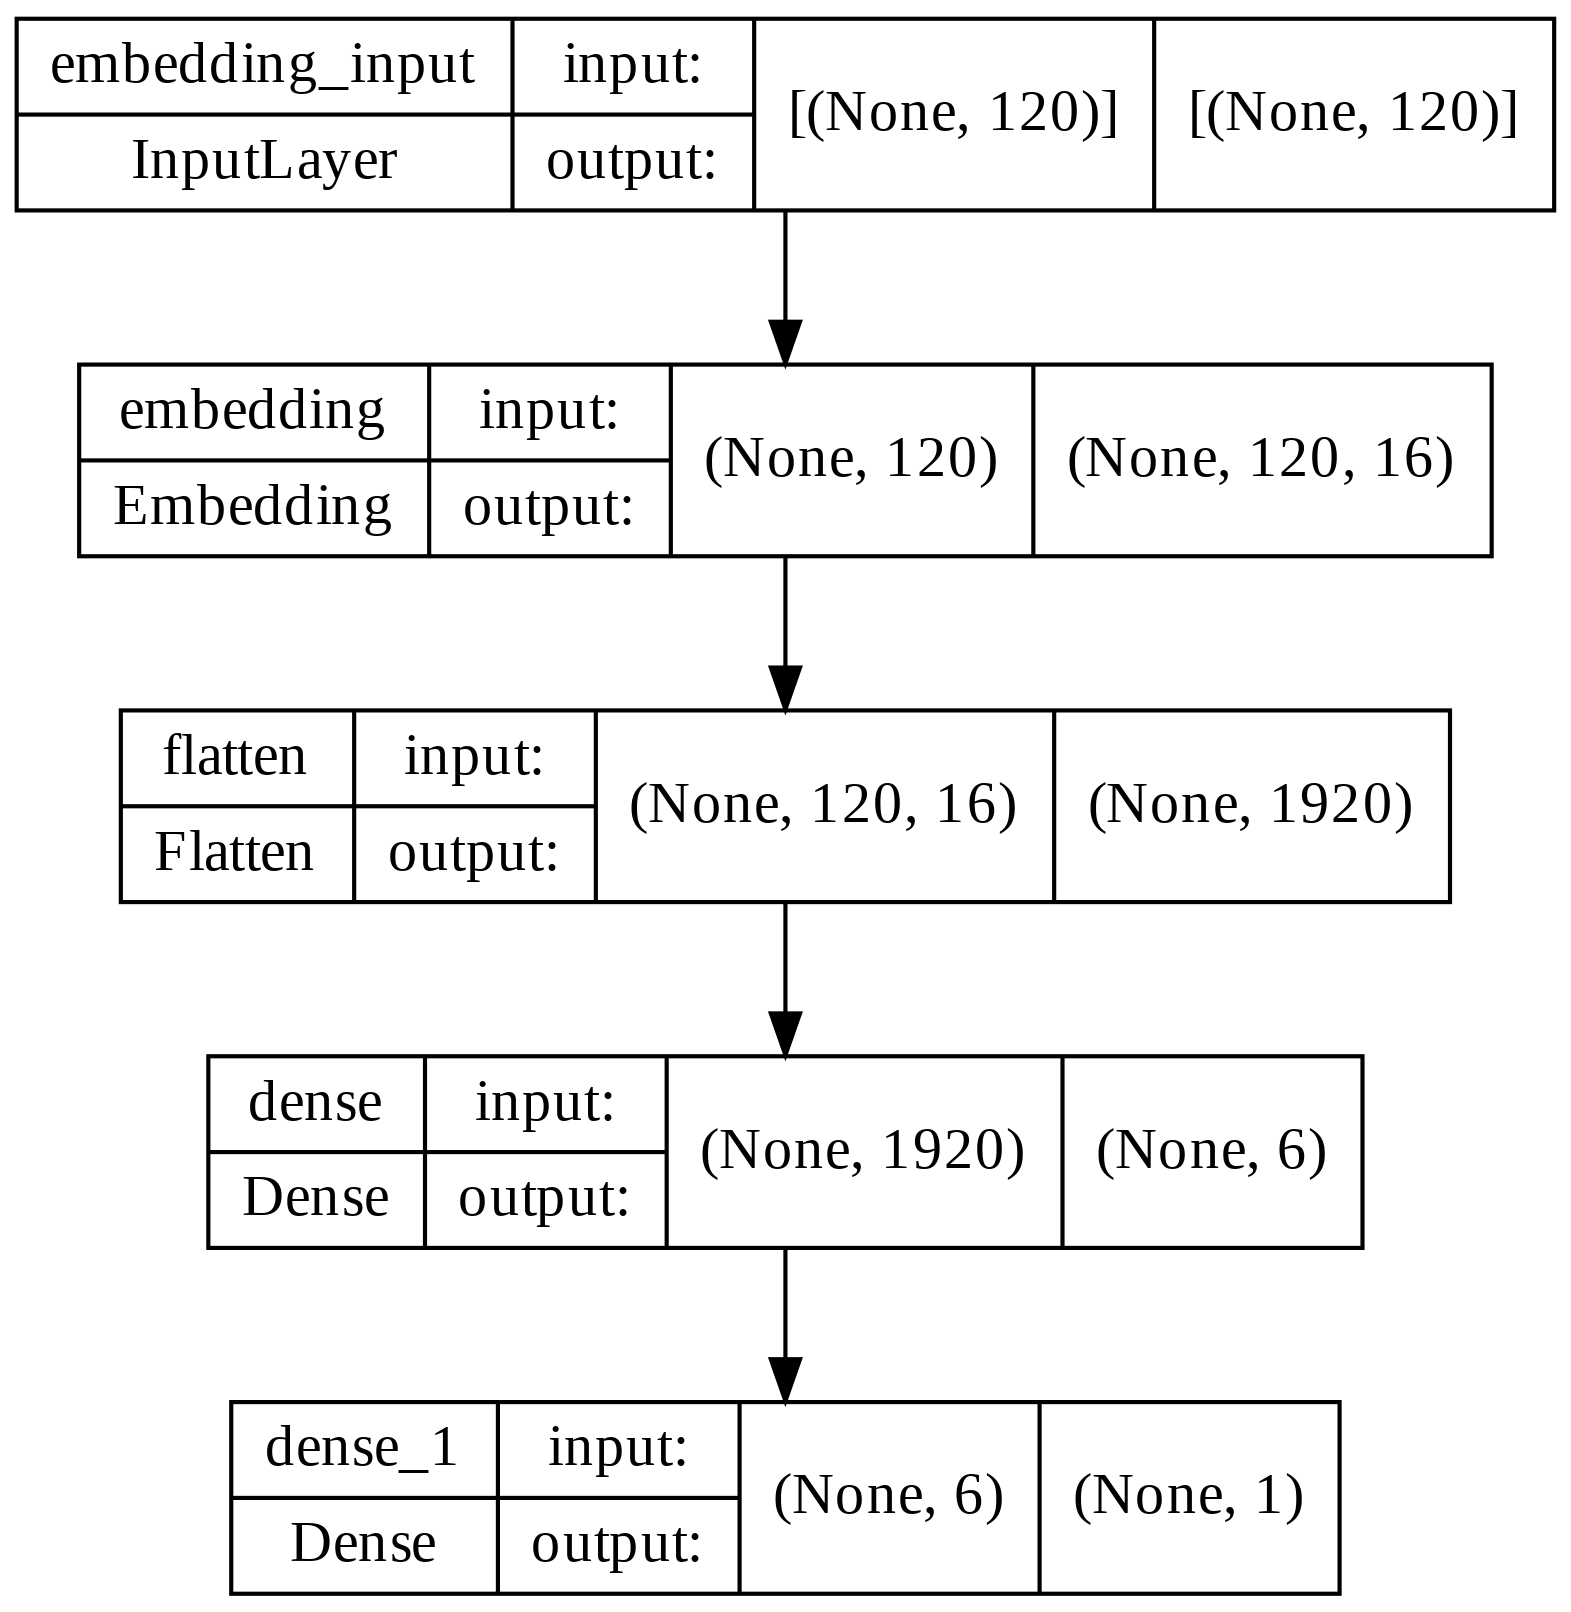

In [9]:
plot_model(model, show_shapes=True, dpi=300)

In [ ]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Результаты на наборе обучения дадут нам точность примерно 1,00, и на валидации - примерно 0,82. Скорее всего, здесь оверфиттинг. Мы рассмотрим некоторые стратегии, чтобы избежать этого позже
Теперь нам нужно визуализировать embedding. Мы начнем с получения результатов слоя Embedding, который в нашей модели -  нулевой слой. Мы можем получить веса и вывести их размерность следующим образом:

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

Мы можем видеть, что это массив 10000х16, у нас есть 10 000 слов в нашем корпусе, и мы работаем в 16-мерном массиве. Чтобы визуализовать его, нам нужна вспомогательная функция, чтобы вернуть наш word_index обратно в слова. Функция `reverse_word_index` была определена выше.
Запишем векторы и их метаданные в файлы.  TensorFlow Projector читает этот тип файла и использует его для построения векторов в трехмерном пространстве, чтобы мы могли их визуализировать.
В файл векторов мы просто записываем значение каждого из элементов в массиве встраиваний, т.е. значение в каждом измерении вектора для этого слова. Для массива метаданных мы просто записываем соответствующие векторам слова.

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Выгрузить эти файлы можно просто из навигатора, которое находится справа в меню "files", или при помощи кода ниже.
Чтобы визуализировать результаты, перейдите в TensorFlow Embedded Projector [https://projector.tensorflow.org] и нажмите там кнопку «Load data» слева.
Включите флажок 'sphereize data' в левом верхнем углу, и вы увидите двоичную кластеризацию данных. Экспериментируйте с поиском слов, или нажимайте на синие точки на диаграмме, представляющие слова.

In [ ]:


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [ ]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)